## Идея:

**Идея:** реализовать автоматическую генерацию ответа к отзыву. Таким образом совместив задачу сентимент анализа и генерации текста.

Используются предобученные модели: **RoBERTa** для анализа и **Mistral** для генерации.

[Датасет](https://huggingface.co/datasets/Yelp/yelp_review_full):
* содержит 650к/50к отзывов с платформы Yelp, об услугах, сервисах, ресторанах и пр.
* имеет 5 классов — 5 звёзд
* мультиязычный

## Сентимент анализ

### Загрузка и предварительная обработка датасета

In [ ]:
!pip install -U datasets huggingface_hub fsspec;

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [ ]:
from datasets import load_dataset

ds = load_dataset("yelp_review_full", trust_remote_code=True)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'yelp_review_full' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'yelp_review_full' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Немного нормализуем датасет, для этого создадим соответствующие функции:
1. Очистка текста от лишних символов, эмодзи и прочего

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9.,!?;:()\"'-]", " ", text)
    return text.strip()

2. Переразметим данные с оценки 0-5, до 0-3(отрицательный, нейтральный и положительный)

In [ ]:
def convert_label(example):
    rating = example["label"] + 1
    if rating in [4, 5]:
        label = 2  # positive
    elif rating == 3:
        label = 1  # neutral
    else:
        label = 0  # negative
    example["label"] = label
    return example

Тут появилась идея оставить только англоязычные тексты, т.к. латиница != английский. Но посмотрев сколько будет это всё обрабатываться, стало не так важно, хотя думаю это повысило бы метрики.

Тем не менее, некоторый функционал реализовал, осталось буквально выборку сделать и протестить

In [ ]:
# !pip install langdetect

In [ ]:
# from langdetect import detect

# def is_english(example):
#     try:
#         return detect(example['text']) == 'en'
#     except:
#         return False  # если не удалось определить язык, исключаем

In [ ]:
# ds = ds.filter(is_english)

Здесь сократили тренировочный и и валидационный датасет, т.к. 700к отзывов собирались обучатся 5 дней на встроенном в коллабе железе..

In [ ]:
from datasets import DatasetDict, concatenate_datasets

#ds = DatasetDict({
#    'train': ds['train'].shuffle(seed=42).select(range(13000)),
#    'test': ds['test'].shuffle(seed=42).select(range(1000))
#})

train_ds = ds['train']

pos = train_ds.filter(lambda x: x['label'] in [3, 4])
neu = train_ds.filter(lambda x: x['label'] == 2)
neg = train_ds.filter(lambda x: x['label'] in [0, 1])

pos = pos.shuffle(seed=42).select(range(5000))
neu = neu.shuffle(seed=42).select(range(5000))
neg = neg.shuffle(seed=42).select(range(5000))
test_ds = ds['test'].shuffle(seed=42).select(range(2500))

balanced_train = concatenate_datasets([pos, neu, neg]).shuffle(seed=42)

ds = DatasetDict({
    'train': balanced_train,
    'test': test_ds
})

In [ ]:
ds = ds.map(lambda x: {"text": clean_text(x["text"])})
ds = ds.map(convert_label)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
from collections import Counter

counter = Counter(ds['train']['label'])
label_names = {0: "negative", 1: "neutral", 2: "positive"}
for label_id, count in counter.items():
    print(f"{label_names[label_id]}: {count} примеров")

negative: 5000 примеров
neutral: 5000 примеров
positive: 5000 примеров


### Подготовка токенизатора и DataCollator

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

def tokenize_function(example):
    return tokenizer(example["text"], max_length=128, truncation=True)

In [ ]:
tokenized_dataset = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Добавили паддинг

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Настройка параметров обучения

In [ ]:
!pip install evaluate

Указали метрики

In [ ]:
import numpy as np
import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

Для красивого вывода 🌠

In [ ]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device);

Параметры обучения

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="results",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

Параметры модели

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

/tmp/ipython-input-85-3091136456.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Обучение

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.485963,0.800000
2,No log,0.503427,0.786400
3,0.593100,0.529911,0.792400


TrainOutput(global_step=705, training_loss=0.5455823965951906, metrics={'train_runtime': 1083.9856, 'train_samples_per_second': 69.189, 'train_steps_per_second': 1.084, 'total_flos': 2960025949440000.0, 'train_loss': 0.5455823965951906, 'epoch': 3.0})

### Предсказание тональности

Создали пайп и загрузили лучшую модель

In [ ]:
from transformers import pipeline

pipe = pipeline(
    "sentiment-analysis",
    model=trainer.model,           # используем обученную модель из Trainer
    tokenizer=tokenizer,           # передаём токенизатор, связанный с моделью
    device=0                      # явно указываем использовать GPU с индексом 0 (если доступен)
)

Device set to use cuda:0


Используем валидационный датасет

In [ ]:
targets = ds["test"]["label"]
predictions = []

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset

for out in pipe(KeyDataset(ds["test"], "text"), batch_size=16, truncation=True):
    predictions.append(label2id[out["label"]])

Матрица ошибок

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1061
           1       0.55      0.64      0.59       474
           2       0.90      0.83      0.86       965

    accuracy                           0.82      2500
   macro avg       0.78      0.79      0.78      2500
weighted avg       0.83      0.82      0.83      2500



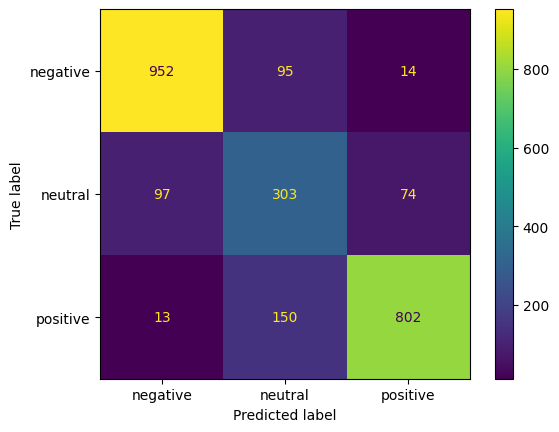

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm, display_labels=np.array(list(label2id.keys()))).plot()

Тут получаем предсказание с пользовательским отзывом

In [ ]:
def predict_sentiment(text, pipeline):
    """
    Получить предсказание сентимента для заданного текста.

    Args:
        text (str): Входной текст для анализа.
        pipeline (transformers.Pipeline): Предобученный пайплайн для классификации текста.

    Returns:
        dict: Результат с ключами 'label' (название класса) и 'score' (уверенность).
    """
    label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
    }

    result = pipeline(text)[0]  # Получаем первый результат (один текст)
    label = label_map.get(result['label'], result['label'])
    score = result['score']
    return {"label": label, "score": score}

In [ ]:
user_text = "I love this product! It works great. You are best!"

prediction = predict_sentiment(user_text, pipe)
print(f"Sentiment: {prediction['label']}, Confidence: {prediction['score']:.2f}")

Sentiment: positive, Confidence: 0.98


На одной из попыток был 1.00..

## Генерация

In [ ]:
# from huggingface_hub import login
# login(new_session=False)

In [ ]:
#generator = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.1", device=0)

In [ ]:
!pip install optimum optimum[onnxruntime] auto-gptq;

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("TheBloke/Mistral-7B-Instruct-v0.1-GPTQ", use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ",
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

Some weights of the model checkpoint at TheBloke/Mistral-7B-Instruct-v0.1-GPTQ were not used when initializing MistralForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11

Few-shot **промпты**

Примеры никак не повышают метрики :(

In [ ]:
def build_prompt(review_text, sentiment_label):
    base_prompt = (
        f'Review: "{review_text}"\n'
        f'You are a customer service assistant. '
        f'Generate a short, polite and professional response to the review.\n'
    )

    if sentiment_label == 'positive':
        task_instruction = (
            "Thank the customer warmly for their feedback and encourage them to return or shop again.\n\n"
            # "Example 1: 'Thank you so much for your kind words! We're thrilled you enjoyed your experience.'\n"
            # "Example 2: 'We really appreciate your feedback. Come back again soon!'\n"
            # "Example 3: 'Thanks for sharing your positive review! Hope to see you again.\n'"
            # "Example 5: 'So glad to hear you’re happy with the product. Thank you!'\n"
            # "Example 6: 'Thanks a lot! Your satisfaction means a lot to us.'\n\n"
            # "Output only response, no extra text.\n\n"
            "Response:[llm_response]"
        )
    elif sentiment_label == 'neutral':
        task_instruction = (
            "Thank the customer politely and let them know that their feedback will be considered to improve the service.\n\n"
            # "Example 1: 'Thank you for your feedback. We'll take it into consideration.'\n"
            # "Example 2: 'We appreciate your input and will use it to improve our service.'\n"
            # "Example 3: 'Thanks for your comment. It helps us make things better.'\n"
            # "Example 4: 'We hear you and value your opinion. Thank you.'\n"
            # "Example 5: 'Your feedback has been noted. Thank you for taking the time.'\n\n"
            "Output only response, no extra text.\n\n"
            "Response:[llm_response]"
        )
    else:  # negative
        task_instruction = (
            "Apologize sincerely for the negative experience and ask how the service or product can be improved.\n\n"
            # "Example 1: 'We're sorry to hear about your experience. How can we improve?'\n"
            # "Example 2: 'Apologies for the inconvenience. We’d love to hear how we can make things right.'\n"
            # "Example 3: 'Thank you for your honesty. Please let us know what went wrong.'\n"
            # "Example 4: 'We regret the issue you faced. Let us know how we can do better.'\n"
            # "Example 5: 'Sincere apologies for the trouble. Your feedback will help us improve.'\n"
            "Output only response, no extra text.\n\n"
            "Response:[llm_response]"
        )

    return base_prompt + task_instruction

**Генерация ответа**

In [ ]:
import re

def generate_reply(review, sentiment):
    """
      Генерирует ответ на отзыв при помощи LLM и извлекает из результата лишь сам текст ответа.

      Args:
        review (str): Текст пользовательского отзыва.
        sentiment ({'positive', 'neutral', 'negative'}): Определённая ранее тональность отзыва.

      Returns:
        str: Сгенерированный ответ (без служебного промпта).
          Если по шаблону «Response:[llm_response] ...» ничего не найдено,
          функция вернёт исходную генерацию, удалив лишние пробелы.
      """

    response = generator(build_prompt(review, sentiment), max_length=100, temperature=0.9, top_p=0.95, do_sample=True)[0]['generated_text']

    match = re.search(r"Response:\[llm_response\](.*)", response, re.DOTALL)

    if match:
        # Чистим от кавычек и пробелов
        return match.group(1).strip(' "\n')
    else:
          # Фолбэк: возвращаем как есть
        return response.strip()

**Функция полного процесса анализа и генерации**

In [ ]:
def process_review(review, pipe):
    """
    Полный пайплайн: определяет тональность и генерирует ответ.

    Args:
        review: Текст отзыва.
        pipe: Hugging Face pipeline модели сентимент‑анализа.

    Returns:
        str: Строка с готовым ответом.
    """

    sentiment = predict_sentiment(review, pipe)
    reply = generate_reply(review, sentiment['label'])
    return reply

**Обработка одного отзыва**

In [ ]:
reply = process_review(user_text, pipe)
print("Ответ:", reply)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Ответ: Thank you so much for taking the time to share your positive feedback with us. We're thrilled to hear that our product is working well for you. We value your business and would love for you to continue shopping with us or to return for any future needs. Thank you again for your loyalty and support.


**ROUGE**

In [ ]:
reference_responses = {
    "positive": [
        "Thank you so much for your kind words! We're thrilled you enjoyed your experience.",
        "We really appreciate your feedback. Come back again soon!",
        "Thanks for sharing your positive review! Hope to see you again.",
        "So glad to hear you’re happy with the product. Thank you!",
        "Thanks a lot! Your satisfaction means a lot to us."
    ],
    "neutral": [
        "Thank you for your feedback. We'll take it into consideration.",
        "We appreciate your input and will use it to improve our service.",
        "Thanks for your comment. It helps us make things better.",
        "We hear you and value your opinion. Thank you.",
        "Your feedback has been noted. Thank you for taking the time."
    ],
    "negative": [
        "We're sorry to hear about your experience. How can we improve?",
        "Apologies for the inconvenience. We’d love to hear how we can make things right.",
        "Thank you for your honesty. Please let us know what went wrong.",
        "We regret the issue you faced. Let us know how we can do better.",
        "Sincere apologies for the trouble. Your feedback will help us improve."
    ]
}

In [ ]:
from evaluate import load

rouge_evaluator = load("rouge")

def get_rouge(generated, sentiment, reference_dict):
    """
    Посчитать ROUGE‑1 и ROUGE‑L для одного сгенерированного ответа.

    Args:
        generated: Сгенерированный ответ.
        sentiment: Метка тональности (ключ в ``reference_dict``).
        reference_dict: Словарь вида ``{'positive': [...], ...}``.

    Returns:
        dict: {'rouge1': f1, 'rougeL': f1}.
    """
    references = reference_dict[sentiment]

    scores = rouge_evaluator.compute(
        predictions=[generated],
        references=[references],
        use_stemmer=True,
    )

    return {"rouge1": scores["rouge1"], "rougeL": scores["rougeL"]}

In [ ]:
rouge_scores = get_rouge(reply, prediction['label'], reference_responses)
print(rouge_scores)

{'rouge1': np.float64(0.3055555555555555), 'rougeL': np.float64(0.3055555555555555)}


**Semantic Similarity**

In [ ]:
!pip install sentence-transformers;

In [ ]:
from sentence_transformers import SentenceTransformer, util

semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # лёгкая и быстрая

In [ ]:
def get_max_semantic_similarity(generated_text, references):
    """
    Вычислить максимальную семантическую близость между
    сгенерированным ответом и списком эталонов.

    Args:
        generated_text: Ответ, полученный от LLM.
        references: Список строк‑эталонов.

    Returns:
        Наибольшее cosine‑similarity в диапазоне ``[0, 1]``.
    """

    ref_embeddings = semantic_model.encode(references, convert_to_tensor=True)
    gen_embedding = semantic_model.encode(generated_text, convert_to_tensor=True)

    cosine_scores = util.cos_sim(gen_embedding, ref_embeddings)
    max_score = float(cosine_scores.max())
    return max_score

In [ ]:
sim_score = get_max_semantic_similarity(reply, prediction['label'])
print("Semantic similarity:", sim_score)

Semantic similarity: 0.30261528491973877


Тут решил сделать функцию, которая вычислит обе метрики и запишет таблицей

In [ ]:
def evaluate_response(reply, sentiment):
    """
    Собрать метрики ROUGE и semantic similarity для ответа.

    Args:
        reply: Сгенерированный ответ.
        sentiment: Тональность (positive / neutral / negative).

    Returns:
        Словарь с метками и тремя метриками.
    """

    results = []

    rouge = get_rouge(reply, prediction['label'], reference_responses)
    sim = get_max_semantic_similarity(reply, prediction['label'])

    results.append({
        "Sentiment": sentiment,
        "Reply": reply,
        "ROUGE-1": rouge["rouge1"],
        "ROUGE-L": rouge["rougeL"],
        "SemanticSim": sim
    })
    return results

In [ ]:
res_tab = evaluate_response(reply, prediction['label'])

import pandas as pd

df = pd.DataFrame(res_tab)
print(df)

  Sentiment                                              Reply   ROUGE-1  \
0  positive  Thank you so much for taking the time to share...  0.305556   

    ROUGE-L  SemanticSim  
0  0.305556     0.302615  


Как итог метрики грустные😞

Как улучшить пока не понимаю

## Итоги:

**Как итог:**
1. Объединили и решили две задачи: сентимет анализ и генерацию текста
2. Воспользовались различными моделями для различных задач
3. Воспользовались различными API
4. Ответ на отзыв генерируется, однако оценка ответа низкая
5. Работа с промптом особых улучшений не приносит, возможно проблема в модели
6. Были созданы пользовательские функции
7. В целом можно вырастить из этого какую-то AutoML задачу, чтобы по оценкам ответов LLM, менять промпт или ещё какие параметры, пока метрики не станут качественными, но кажется это займёт много времени.